# Real Estate Data Analysis

[Data Source](https://drive.google.com/file/d/1hDWtr00dFzbeW4u4KEVPVUivu8ZksYKm/view)

**Objective**: Exploratory analysis of the real estate dataset and train a linear regression model to estimate house price of unit area. Features combination of *house age*, *distance to the nearest MRT station*, and *number of convenience stores*.


In [235]:
## import libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
# modeling libraries
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Preprocessing

### Load data

In [236]:
df=pd.read_csv('data/real_estate.csv')
print('shape of the dataset:',df.shape)
df.head()

shape of the dataset: (414, 8)


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [237]:
# rename columns: Replace 'space' with '_'
df.columns=df.columns.str.replace(' ','_')

In [238]:
# drop the 'No' columns, it is a duplicate of 'index' 
df=df.drop(columns='No')
df.sample(5)

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
96,2013.417,6.4,90.45606,9,24.97433,121.54310,59.5
212,2013.333,17.6,1805.66500,2,24.98672,121.52091,31.1
70,2013.583,6.6,90.45606,9,24.97433,121.54310,59.0
189,2012.917,16.3,4066.58700,0,24.94297,121.50342,20.5
138,2013.167,10.0,942.46640,0,24.97843,121.52406,43.5


In [239]:
# check datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1_transaction_date                     414 non-null    float64
 1   X2_house_age                            414 non-null    float64
 2   X3_distance_to_the_nearest_MRT_station  414 non-null    float64
 3   X4_number_of_convenience_stores         414 non-null    int64  
 4   X5_latitude                             414 non-null    float64
 5   X6_longitude                            414 non-null    float64
 6   Y_house_price_of_unit_area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


### Missing & Duplicated values

In [240]:
# Missing values
print('Missing values per column:\n',df.isnull().sum(axis=0))
# Duplicate values
print('\n Duplicates\n',df.duplicated().sum())

Missing values per column:
 X1_transaction_date                       0
X2_house_age                              0
X3_distance_to_the_nearest_MRT_station    0
X4_number_of_convenience_stores           0
X5_latitude                               0
X6_longitude                              0
Y_house_price_of_unit_area                0
dtype: int64

 Duplicates
 0


The data does not have any missing value or duplicated values

### Outliers

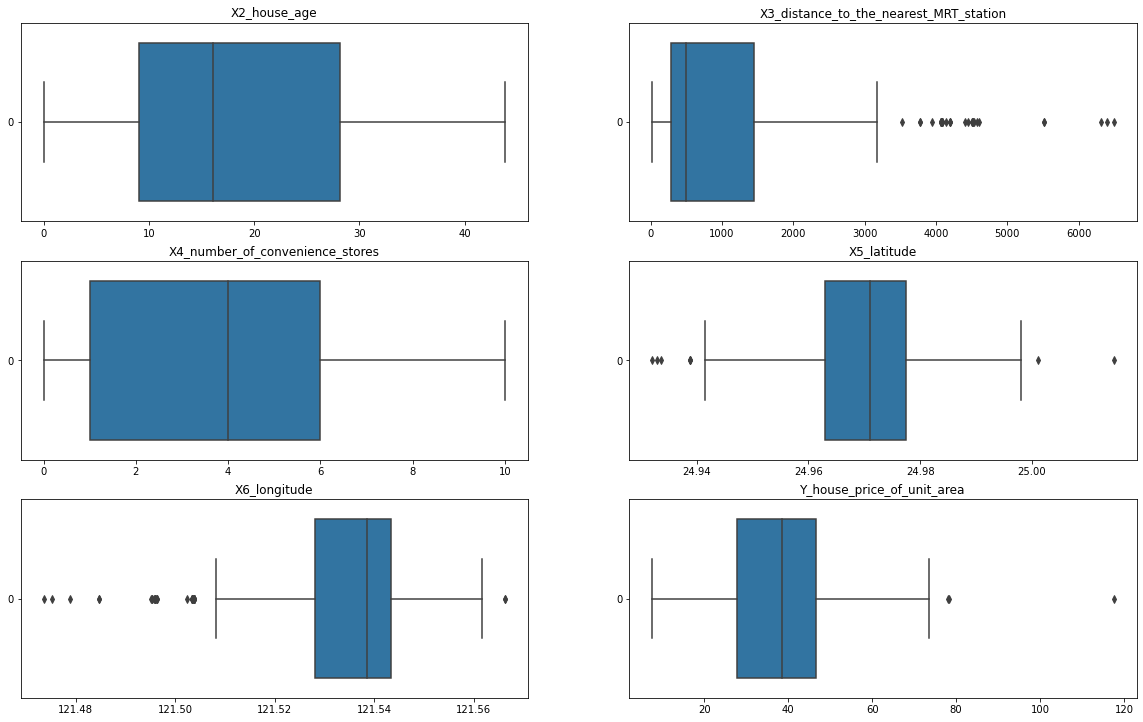

In [241]:
# plot a box plot for all numerical values 
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=3, ncols=2,figsize=(20,5))

# Define arrays to plot on 
ax_array = ax_array.flatten()

# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.boxplot(data=df.iloc[:,i+1], orient="h", ax = ax)
  # Set the title as the variable name
  ax.set_title(df.columns[i+1])
  fig.subplots_adjust(top=2)

plt.show()

Column *X3_distance_to_the_nearest_MRT_station* has outliers.

In [242]:
# Identify the outliers using Tukey Rule to determine whether ro remove or not

cols = ['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(df,i)
  print("Column ",i,"Outliers: ",outliers_Tukey)

Column  X2_house_age Outliers:  []
Column  X3_distance_to_the_nearest_MRT_station Outliers:  [8, 30, 35, 40, 41, 48, 49, 58, 73, 87, 89, 116, 117, 148, 154, 155, 162, 170, 176, 180, 183, 187, 189, 194, 226, 228, 231, 232, 249, 255, 298, 307, 320, 329, 331, 344, 347, 382, 384, 394, 409]
Column  X4_number_of_convenience_stores Outliers:  []


We will keep the outliers. Given that the size of the outliers is significant in comparison to the size of our dataset. Removing the outliers will cause a  statistical significance on our data.

### Scaling


#### Density plots

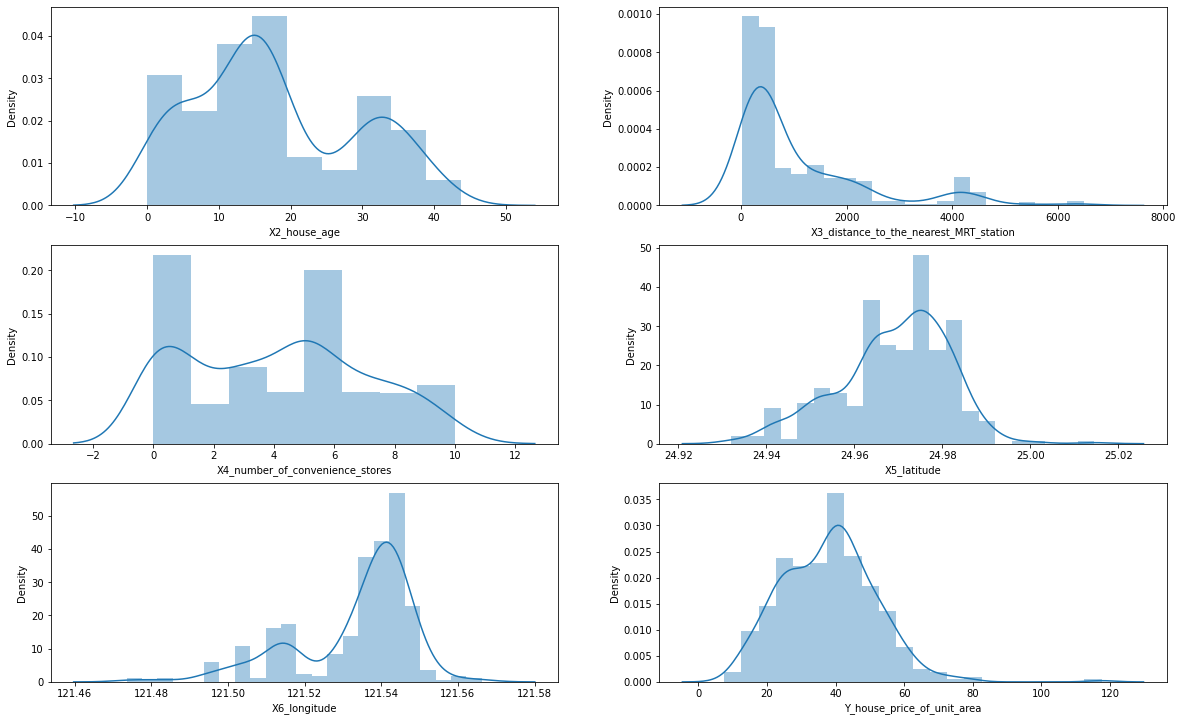

In [243]:
# plot a density plot for all numerical values 
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=3, ncols=2,figsize=(20,5))

# Define arrays to plot on 
ax_array = ax_array.flatten()

# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.distplot(df.iloc[:,i+1], ax=ax)
  fig.subplots_adjust(top=2)

plt.show()

#### Standard Scaler

In [244]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features=['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']
X=df[['X2_house_age','X3_distance_to_the_nearest_MRT_station','X4_number_of_convenience_stores']]
X[features] = scaler.fit_transform(X.values)
X.sample(5)

,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores
303,1.809294,-0.511013,-1.391638
407,-1.099646,1.051185,-1.391638
85,-1.556639,-0.590931,1.667503
61,-1.090858,-0.653844,0.647789
393,-0.071411,-0.092406,-0.032020


Our dataset has columns with different units.To be sure that the model treats both variables equally we have to scale the data by transformation of data into z-scores (by subtracting the feature mean and divding by the feature standard deviation). It's purpose is to ensure all features are on a common scale without distorting the relative differences between the instance values.

### Transform

In [248]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method = 'yeo-johnson')
X[features] = scaler.fit_transform(X.values)
X.sample(5)

,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores
19,-1.630697,-1.895686,0.989532
171,-1.369710,-0.482914,0.352626
303,1.603687,-0.324427,-1.444439
238,-0.331796,0.299679,-1.444439
217,0.940388,-0.516545,0.675576


**Justification**: Some Machine Learning models, like Linear and Logistic regression, assume that the variables follow a normal distribution. Our features  does not follow a normal distribtution. By applying some transformations to these features, we can ensure that this can increase the performance of our models.

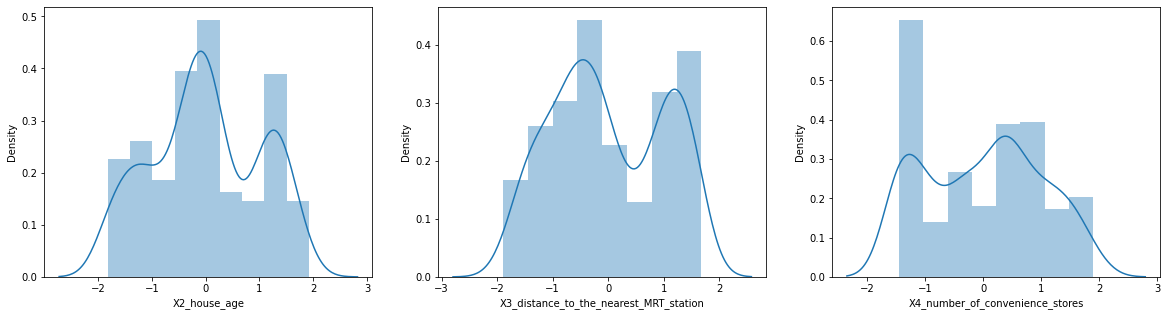

In [249]:
# Distribution after transfrom and scaling
# Construct the subplot matrix
fig, ax_array = plt.subplots(nrows=1, ncols=3,figsize=(20,2))
# Define arrays to plot on 
ax_array = ax_array.flatten()
# Iteratively plot every variable as a boxplot
for i, ax in enumerate(ax_array):
  sns.distplot(X.iloc[:,i], ax=ax)
  fig.subplots_adjust(top=2)

plt.show()

In [252]:
df.head()

,X1_transaction_date,X2_house_age,X3_distance_to_the_nearest_MRT_station,X4_number_of_convenience_stores,X5_latitude,X6_longitude,Y_house_price_of_unit_area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1
